In [13]:
%matplotlib inline
import sys
sys.path.append('..')
from preamble import *
import os
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a synthetic dataset
X, y = make_blobs(random_state=0)
print("X.shape:", X.shape)
print("y.shape:", y.shape)

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

from sklearn.datasets import load_iris
iris = load_iris()
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

X.shape: (100, 2)
y.shape: (100,)
Test set score: 0.88


- 모델 매개변수 튜닝을 통한 일반화 성능 개선 
- 가장 널리 사용되는 방법은 Grid Search (그리드 탐색)

#### Simple Grid-Search
- SVC 모델에서 가장 중요한 매개변수는 gamma, C
- 그리드 탐색 범위 설정 예
  - gamma: [0.001, 0.01, 0.1, 1, 10, 100]
  - C: [0.001, 0.01, 0.1, 1, 10, 100]
  - 총 6x6=36개의 조합에 대하여 반복적으로 새로운 모델 생성 및 평가
  - 가장 좋은 성능을 보여주는 gamma와 C의 조합을 찾음

In [5]:
# naive grid search implementation
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_test, y_test)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


- 위 0.97의 정확도는 전혀 새로운 데이터에 대한 성능으로 이어지지 않을 수 있다.
- 즉, 위 예제에서 사용한 테스트 데이터는 모델 구성시에 사용을 해버렸기 때문에 이 모델이 얼마나 좋은지 평가하는 데 더 이상 사용할 수 없다.

#### The danger of overfitting the parameters and the validation set
- 검증 데이터 세트 (Valudation Set) 필요
  - 모델 파라미터 튜닝 용도
- 모델을 구성할 때 훈련 데이터 세트와 검증 데이터 세트를 활용

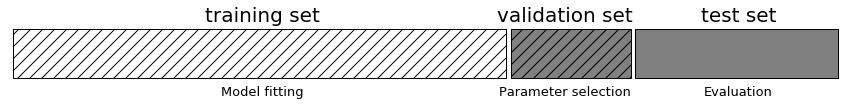

In [6]:
mglearn.plots.plot_threefold_split()

In [16]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)

# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)

print("Size of training set: {}, size of validation set: {},size of test set: {}\n".format(
    X_train.shape[0], 
    X_valid.shape[0], 
    X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the validation set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)

#[NOTE] 훈련 데이터와 검증 데이터를 합쳐서 다시 모델을 구성함
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84, size of validation set: 28,size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


- 위 예제를 통하여 전혀 새로운 테스트 데이터에 대해 생성한 모델은 92%의 정확도로 분류한다고 볼 수 있음

#### Grid-search with cross-validation
- 그리드 탐색에서도 교차 검증 필요
  - 위 두 예제에서 최고의 성능을 보여주는 파라미터가 변경된 점을 주의

In [17]:
# reference: manual_grid_search_cv
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)

#[NOTE] 훈련 데이터와 검증 데이터를 합쳐서 다시 모델을 구성함
svm.fit(X_trainval, y_trainval)

test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.97
Best parameters:  {'C': 100, 'gamma': 0.01}
Test set score with best parameters: 0.97


- 위 예에서는 반복적인 모델 생성 작업이 36 * 5 = 180번 이루어짐
  - 즉, 시간이 많이 소요됨에 주의

C:\Users\yi112\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\yi112\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\yi112\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\yi112\Anaconda3\lib\site-packages\sklearn\utils\

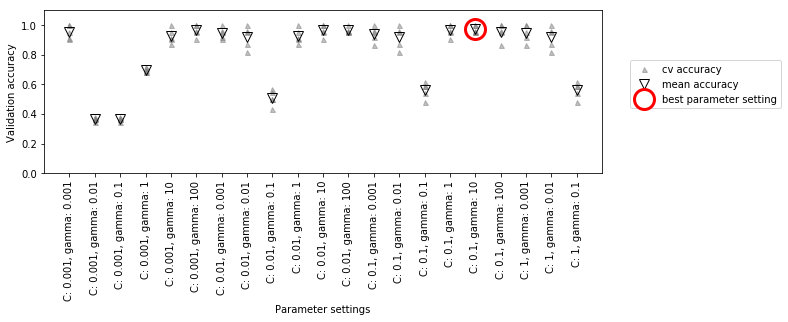

In [19]:
mglearn.plots.plot_cross_val_selection()

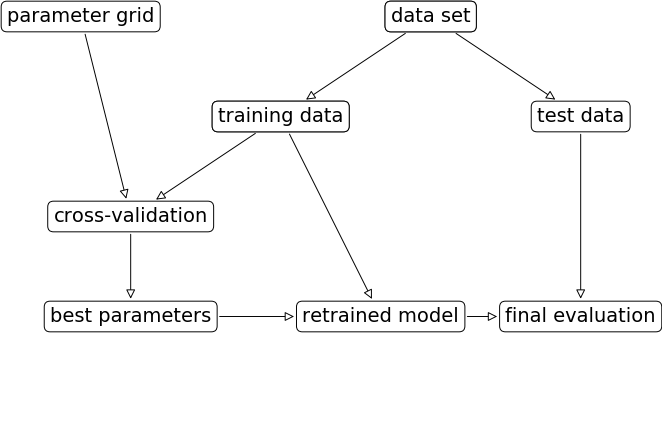

In [20]:
mglearn.plots.plot_grid_search_overview()

- model_selection.GridSearchCV
  - 교차 검증을 사용하는 그리드 탐색을 통한 모델 구성
  - 분류에는 StratifiedKFold 사용함
  - 회귀에는 KFold 사용함
- 다른 estimator (or 모델)를 사용하여 만들어지는 estimator를 메타 추정기(meta-estimator)라고 함.
  - GridSearchCV는 가장 널리 사용되는 메타 추정기
  - scikit-learn에서는 MetaEstimatorMixin 클래스를 상속한 모델을 메타 추정기라고 부름
  - 메타 추정기 예
    - GridSearchCV
    - RandomForest
    - GradientBoosting
    - RFE
    - ...
    
- 우선 모델에 들어갈 각 매개변수 값을 사전(Dict)타입으로 구성
  - 문자열 매개변수 이름을 모델(예:SVC)에 설정된 매개변수와 동일하게 맞춤  

In [21]:
param_grid = {    'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


- GridSearchCV 생성
  - fold의 개수는 cv=5와 같이 설정

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

- 훈련 데이터와 테스트 데이터 분리

In [23]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [24]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

- 모델 구성시 사용하지 않은 완전히 새로운 데이터인 X_test와 y_test를 사용하여 모델 평가

In [25]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


In [26]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97


- 위 두 예에서 grid_search.score() 메소드와 grid_search.best\_score\_ 속성은 매우 큰 차이
  - grid_search.score() 메소드
    - 새로운 데이터인 테스트 데이터 셋을 통한 모델 평가 점수
  - grid_search.best\_score\_ 속성
    - 훈련 데이터에 대하여 교차 검증의 최고 점수

In [27]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### Analyzing the result of cross-validation
- grid_search.cv\_results\_
  - 그리드 탐색에 대한 교차 검증 결과 정보가 상세히 들어 있는 속성

In [28]:
import pandas as pd
# convert to Dataframe
results = pd.DataFrame(grid_search.cv_results_)

print(results.columns)
# show the first 5 rows
# display(results.head(5))
display(results)

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_C', 'param_gamma', 'params',
       'rank_test_score', 'split0_test_score', 'split0_train_score',
       'split1_test_score', 'split1_train_score', 'split2_test_score',
       'split2_train_score', 'split3_test_score', 'split3_train_score',
       'split4_test_score', 'split4_train_score', 'std_fit_time',
       'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,...,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.91e-04,4.07e-04,0.37,0.37,...,4.83e-04,4.98e-04,0.01,2.85e-03
1,6.09e-04,0.00e+00,0.37,0.37,...,4.97e-04,0.00e+00,0.01,2.85e-03
2,5.99e-04,4.09e-04,0.37,0.37,...,4.89e-04,5.01e-04,0.01,2.85e-03
3,4.00e-04,6.02e-04,0.37,0.37,...,4.91e-04,4.91e-04,0.01,2.85e-03
4,6.01e-04,0.00e+00,0.37,0.37,...,4.91e-04,0.00e+00,0.01,2.85e-03
5,5.97e-04,4.01e-04,0.37,0.37,...,4.87e-04,4.91e-04,0.01,2.85e-03
6,4.00e-04,1.96e-04,0.37,0.37,...,4.90e-04,3.92e-04,0.01,2.85e-03
7,5.96e-04,4.09e-04,0.37,0.37,...,4.87e-04,5.01e-04,0.01,2.85e-03
8,5.94e-04,4.07e-04,0.37,0.37,...,4.85e-04,4.98e-04,0.01,2.85e-03
9,4.01e-04,2.01e-04,0.37,0.37,...,4.92e-04,4.01e-04,0.01,2.85e-03


- heatmap을 사용한 mean_test_score를 각 매개변수별로 시각화

[0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.36607142857142855, 0.6964285714285714, 0.9196428571428571, 0.9553571428571429, 0.36607142857142855, 0.36607142857142855, 0.6964285714285714, 0.9285714285714286, 0.9642857142857143, 0.9464285714285714, 0.9196428571428571, 0.5089285714285714, 0.9285714285714286, 0.9642857142857143, 0.9642857142857143, 0.9375, 0.9196428571428571, 0.5625, 0.9642857142857143, 0.9732142857142857, 0.9553571428571429, 0.9464285714285714, 0.9196428571428571, 0.5625]

(36,)


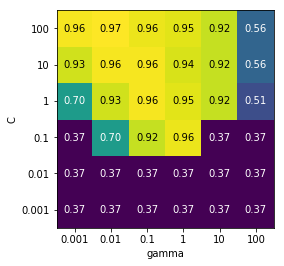

In [29]:
print([x for x in results.mean_test_score])
print()

print(results.mean_test_score.shape)

scores = np.array(results.mean_test_score).reshape(6, 6)

# plot the mean cross-validation scores
mglearn.tools.heatmap(
    scores, 
    xlabel='gamma', 
    xticklabels=param_grid['gamma'],
    ylabel='C', 
    yticklabels=param_grid['C'], 
    cmap="viridis"
)

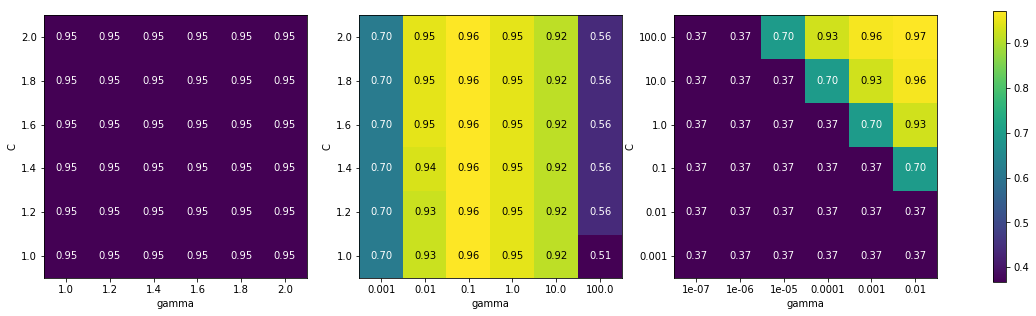

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

param_grid_linear  = {'C': np.linspace(1, 2, 6),  'gamma':  np.linspace(1, 2, 6)}
param_grid_one_log = {'C': np.linspace(1, 2, 6),  'gamma':  np.logspace(-3, 2, 6)}
param_grid_range   = {'C': np.logspace(-3, 2, 6), 'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

- 첫번째 그래프
  - 매개변수 C와 gamma의 스케일과 범위를 잘못 택하였음을 나타냄
  - 처음에는 더 넓은 범위의 C와 gamma 스케일 및 범위를 택하고, 이후 정확도에 따라 매개변수를 바꾸어 선택할 필요있음<br/><br/>

- 두번째 그래프
  - 세로 띠 형태를 보이므로 gamma 매개변수만 정확도에 영향을 주고 있음을 나타냄
  - 두 가지 케이스
    - C 매개변수는 전혀 중요한 역할을 못할 수 있음
    - C 매개변수의 스케일과 범위를 잘못 선택하였을 수 있음<br/><br/>
    
- 세번째 그래프
  - 그래프 왼쪽 아래에서는 변화가 없음
  - 다시 매개변수 스케일과 범위를 선택하는 과정에서 현재 선택한 것 보다 더 높은 gamma 및 C 값을 선택할 필요성 있음

#### Grid search with asymmetric parameters
- SVC
  - kernel='rbf' 일 때
    - C 매개변수, gamma 매개변수 동시 사용
  - kernel='linear' 일 때
    - C 매개변수만 사용
    - gamma 매개변수는 사용하지 않음

In [31]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [32]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [33]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

,0,1,2,3,...,38,39,40,41
mean_fit_time,0.0008,0.0004,0.001,0.0006,...,0.0002,0,0,0
mean_score_time,0,0,0,0.0004,...,0,0,0,0
mean_test_score,0.37,0.37,0.37,0.37,...,0.95,0.97,0.96,0.96
mean_train_score,0.37,0.37,0.37,0.37,...,0.97,0.98,0.99,0.99
param_C,0.001,0.001,0.001,0.001,...,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,...,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,...,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
rank_test_score,27,27,27,27,...,11,1,3,3
split0_test_score,0.38,0.38,0.38,0.38,...,0.96,1,0.96,0.96


#### Using different cross-validation strategies with grid-search
- 데이터셋이 매우 크거나 모델 구축 시간이 오래 걸릴 때 사용하는 전략
  - 훈련 데이터 세트와 검증 데이터 세트로의 분리를 한번 만 수행
    - n_splits = 1
  - StratifiedShuffleSplit 또는 ShuffleSplit 사용

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit
shuffle_split = StratifiedShuffleSplit(test_size=.8, n_splits=1)
grid_search = GridSearchCV(SVC(), param_grid, cv=shuffle_split, return_train_score=True)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best cross-validation score: 0.98


In [35]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

,0,1,2,3,...,38,39,40,41
mean_fit_time,0.001,0.001,0,0,...,0,0.001,0,0
mean_score_time,0,0,0,0.00099,...,0.001,0,0,0
mean_test_score,0.37,0.37,0.37,0.37,...,0.92,0.98,0.94,0.94
mean_train_score,0.36,0.36,0.36,0.36,...,1,1,1,1
param_C,0.001,0.001,0.001,0.001,...,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,...,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,...,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
rank_test_score,24,24,24,24,...,13,1,5,5
split0_test_score,0.37,0.37,0.37,0.37,...,0.92,0.98,0.94,0.94


#### Nested cross-validation
- 중첩 교차 검증
  - outer_scores = []
  - 1st Loop: 원본 데이터를 훈련(Training) 데이터와 테스트(Test) 데이터로 분리 및 순회
    - best_params = {}
    - best_score = -np.inf
    - 2nd Loop: 매개변수 그리드를 순회
      - 3rd Loop: 훈련 데이터를 다시 훈련(Training) 데이터와 검증(Validation) 데이터로 분리
      - 3rd Loop의 결과 모델을 평가하여 best_params 및 best_score 조정
    - best_params와 함께 모델 구성하여 평가결과를 outer_scoires에 저장

- 위 중첩 교차 검증과정을 corss_val_score 및 GridSearchCV 조합으로 간단하게 완성

In [37]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.967 1.    0.967 0.967 1.   ]
Mean cross-validation score:  0.9800000000000001


In [38]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    
    # for each split of the data in the outer cross-validation
    # (split method returns indices of training and test part)
    for training_samples, test_samples in outer_cv.split(X, y):
        # find best parameter using inner cross-validation
        best_parms = {}
        best_score = -np.inf

        # iterate over parameters
        for parameters in parameter_grid:
            # accumulate score over inner splits
            cv_scores = []

            # iterate over inner cross-validation
            for inner_train, inner_test in inner_cv.split(X[training_samples], y[training_samples]):
                # build classifier given parameters and training data
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # evaluate on inner test set
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)

                # compute mean score over inner folds
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # if better than so far, remember parameters
                best_score = mean_score
                best_params = parameters

        # build classifier on best parameters using outer training set
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])

        # evaluate
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

In [39]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.967 1.    0.967 0.967 1.   ]


#### Parallelizing cross-validation and grid search
- 다중 CPU 코어 or 다중 GPU 코어 사용
- 사용가능한 프레임워크
  - ipyparallel
    - https://ipyparallel.readthedocs.io
  - spark-sklearn
    - https://github.com/databricks/spark-sklearn